In [ ]:
!pip install deap

# Personalized Meal Planning in Healthcare using Genetic Algorithm

### Import Libararies

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


In [ ]:
RND = 42
random.seed(RND)
np.random.seed(RND)

# Build meal databse
def create_meal(id_, name, mtype, calories, protein, fat, carbs, cost, tags):
    return {
        "meal_id": id_,
        "name": name,
        "type": mtype,
        "calories": calories,
        "protein": protein,
        "fat": fat,
        "carbs": carbs,
        "cost": cost,
        "tags": tags
    }

def make_meals_for_type(base_cal, base_prot, base_fat, base_carbs, cost_base, prefix, mtype, n=8):
    meals = []
    for i in range(n):
        cal = int(np.clip(np.random.normal(base_cal, base_cal*0.12), base_cal*0.6, base_cal*1.4))
        prot = round(max(1, np.random.normal(base_prot, base_prot*0.25)),1)
        fat = round(max(0.5, np.random.normal(base_fat, base_fat*0.3)),1)
        carbs = int(max(5, np.random.normal(base_carbs, base_carbs*0.2)))
        cost = round(max(0.5, np.random.normal(cost_base, cost_base*0.25)),2)
        tags = []
        if random.random() < 0.12:
            tags.append("nuts")
        if random.random() < 0.08:
            tags.append("gluten")
        if random.random() < 0.05:
            tags.append("dairy")
        meals.append((cal, prot, fat, carbs, cost, tags))
    for idx, (cal,prot,fat,carbs,cost,tags) in enumerate(meals):
        yield create_meal(f"{prefix}{idx+1}", f"{prefix}_{idx+1}", mtype, cal, prot, fat, carbs, cost, tags)

breakfasts = list(make_meals_for_type(400, 15, 12, 45, 400, "B", "breakfast", 8))
lunches = list(make_meals_for_type(650, 30, 20, 70, 600, "L", "lunch", 12))
dinners = list(make_meals_for_type(700, 28, 25, 80, 400, "D", "dinner", 12))

meals_df = pd.DataFrame(breakfasts + lunches + dinners).reset_index(drop=True)
meals_df = meals_df.sample(frac=1, random_state=1).reset_index(drop=True)
meals_df.index.name = "idx"

# Map meal indices for DEAP
meals_df["int_id"] = meals_df.index.astype(int)
meal_idx_to_id = meals_df.set_index("int_id")["meal_id"].to_dict()
meal_id_to_idx = {v:k for k,v in meal_idx_to_id.items()}


meal_type_map = {
    "breakfast": list(meals_df[meals_df.type=="breakfast"].int_id),
    "lunch":     list(meals_df[meals_df.type=="lunch"].int_id),
    "dinner":    list(meals_df[meals_df.type=="dinner"].int_id)
}

# patient profile
patient = {
    "id": "P001",
    "name": "Patient A",
    "daily_calories_target": 2000,   # kcal/day
    "daily_protein_target": 70,      # g/day
    "allergies": ["nuts"],
    "budget_week": 10000.0           # budget for 7 days in Rs
}

# fetch meal by index
def get_meal_by_idx(idx):
    row = meals_df.loc[idx]
    return row.to_dict()

def decode_chromosome(chrom):
    """list of 21 integer indices of 7 days each with 3 indices"""
    return [(chrom[d*3+0], chrom[d*3+1], chrom[d*3+2]) for d in range(7)]

def weekly_nutrition_from_idx(chrom):
    days = decode_chromosome(chrom)
    total = {"calories":0, "protein":0, "fat":0, "carbs":0, "cost":0}
    day_summaries = []
    for (b,l,d) in days:
        mb = get_meal_by_idx(b); ml = get_meal_by_idx(l); md = get_meal_by_idx(d)
        day_cal = mb["calories"] + ml["calories"] + md["calories"]
        day_prot = mb["protein"] + ml["protein"] + md["protein"]
        day_fat = mb["fat"] + ml["fat"] + md["fat"]
        day_carbs = mb["carbs"] + ml["carbs"] + md["carbs"]
        day_cost = mb["cost"] + ml["cost"] + md["cost"]
        total["calories"] += day_cal
        total["protein"] += day_prot
        total["fat"] += day_fat
        total["carbs"] += day_carbs
        total["cost"] += day_cost
        day_summaries.append({
            "calories": day_cal, "protein": day_prot, "fat": day_fat, "carbs": day_carbs, "cost": day_cost,
            "b": mb["meal_id"], "l": ml["meal_id"], "d": md["meal_id"]
        })
    avg = {k: total[k]/7 for k in total}
    return {"total": total, "avg": avg, "days": day_summaries}


In [ ]:
# ML MODULE 1: Patient Satisfaction Predictor

def generate_training_data_for_satisfaction(n_samples=200):
    """Generate synthetic training data: meal plan features for satisfaction score"""
    X_train = []
    y_train = []

    for _ in range(n_samples):
        avg_cal = np.random.uniform(1500, 2500)
        avg_prot = np.random.uniform(40, 100)
        cost_ratio = np.random.uniform(0.5, 1.5)  # relative to budget
        variety = np.random.uniform(0.3, 1.0)  # meal variety score
        balance = np.random.uniform(0.5, 1.0)  # nutritional balance

        satisfaction = (
            0.3 * (1.0 - abs(avg_cal - patient["daily_calories_target"]) / patient["daily_calories_target"]) +
            0.2 * (1.0 - abs(avg_prot - patient["daily_protein_target"]) / max(patient["daily_protein_target"], 1)) +
            0.2 * (1.0 - min(cost_ratio, 1.0)) +
            0.15 * variety +
            0.15 * balance
        )
        satisfaction = np.clip(satisfaction, 0.0, 1.0)

        X_train.append([avg_cal, avg_prot, cost_ratio, variety, balance])
        y_train.append(satisfaction)

    return np.array(X_train), np.array(y_train)

# Train satisfaction predictor
X_sat, y_sat = generate_training_data_for_satisfaction(n_samples=500)
satisfaction_model = RandomForestRegressor(n_estimators=50, random_state=RND, max_depth=5)
satisfaction_model.fit(X_sat, y_sat)
print(f"Patient Satisfaction Predictor trained on {len(X_sat)} samples")


# ML MODULE 2: Cost Uncertainty Predictor


def predict_cost_scenarios(base_cost, n_scenarios=5):
    """
    Predict cost scenarios under uncertainty using Monte Carlo simulation
    Returns: array of predicted costs [low, medium, high, ...]
    """
    # Simulate price volatility varying by ±20%
    volatility = 0.20
    scenarios = []
    for _ in range(n_scenarios):

        variation = np.random.normal(1.0, volatility)
        predicted_cost = base_cost * max(0.7, min(1.3, variation))  # clamp to reasonable range
        scenarios.append(predicted_cost)
    return np.array(scenarios)

def get_expected_cost_under_uncertainty(base_cost):
    """Get expected cost considering uncertainty (mean of scenarios)"""
    scenarios = predict_cost_scenarios(base_cost, n_scenarios=20)
    return np.mean(scenarios)

print("Cost Uncertainty Predictor ready (Monte Carlo simulation)")


# Extract meal plan features for ML prediction
def extract_meal_plan_features(individual):
    """Extract features from a meal plan individual for ML prediction"""
    nut = weekly_nutrition_from_idx(individual)
    avg_cal = nut["avg"]["calories"]
    avg_prot = nut["avg"]["protein"]
    total_cost = nut["total"]["cost"]
    budget = patient["budget_week"]
    cost_ratio = total_cost / (budget if budget > 0 else 1.0)

    # Calculate variety
    unique_meals = len(set(individual))
    variety = unique_meals / len(individual)

    # Calculate nutritional balance
    cal_target = patient["daily_calories_target"]
    prot_target = patient["daily_protein_target"]
    cal_balance = 1.0 - min(1.0, abs(avg_cal - cal_target) / cal_target)
    prot_balance = 1.0 - min(1.0, abs(avg_prot - prot_target) / max(prot_target, 1.0))
    balance = (cal_balance + prot_balance) / 2.0

    return [avg_cal, avg_prot, cost_ratio, variety, balance]


Patient Satisfaction Predictor trained on 500 samples
Cost Uncertainty Predictor ready (Monte Carlo simulation)


In [ ]:
# Single-objective maximization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def attr_meal(position):
    pos = position % 3
    if pos == 0:
        return random.choice(meal_type_map["breakfast"])
    elif pos == 1:
        return random.choice(meal_type_map["lunch"])
    else:
        return random.choice(meal_type_map["dinner"])

# Individual generator: 21 genes
def generate_individual():
    return [attr_meal(i) for i in range(21)]

toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ML integrated Fitness Function

def evaluate_individual(individual):
    """
    ML integrated Fitness Evaluation:
    1. Calculates basic nutrition and cost metrics
    2. ML Module 1: Predicts patient satisfaction with this meal plan
    3. ML Module 2: Predicts cost under uncertainty (price volatility)
    4. Combines all factors into fitness score
    """
    nut = weekly_nutrition_from_idx(individual)
    avg_cal = nut["avg"]["calories"]
    avg_prot = nut["avg"]["protein"]
    base_cost = nut["total"]["cost"]

    # Basic nutrition deviation score
    cal_target = patient["daily_calories_target"]
    prot_target = patient["daily_protein_target"]
    cal_dev = abs(avg_cal - cal_target) / cal_target
    prot_dev = abs(avg_prot - prot_target) / (prot_target if prot_target>0 else 1.0)
    nut_deviation = 0.6*cal_dev + 0.4*prot_dev
    nutrition_score = 1.0 / (1.0 + nut_deviation*5.0)

    # Predict cost under uncertainty
    predicted_cost = get_expected_cost_under_uncertainty(base_cost)

    # Cost score based on predicted cost
    budget = patient["budget_week"]
    cost_ratio = predicted_cost / (budget if budget>0 else 1.0)
    if cost_ratio <= 1.0:
        cost_score = 1.0 - (cost_ratio * 0.5)
    else:
        cost_score = max(0.0, 1.0 - (0.5 + (cost_ratio-1.0)*1.2))


    # Extract features and predict satisfaction
    features = extract_meal_plan_features(individual)
    predicted_satisfaction = satisfaction_model.predict([features])[0]

    predicted_satisfaction = np.clip(predicted_satisfaction, 0.0, 1.0) # Ensure satisfaction is in [0, 1] range

    # Penalties for violating constraints
    penalty = 0.0
    allergies = set(patient.get("allergies", []))
    if allergies:
        for idx in individual:
            tags = set(get_meal_by_idx(idx)["tags"])
            if tags & allergies:
                penalty += 1.2
    meal_counts = Counter(individual)
    for m, cnt in meal_counts.items():
        if cnt > 2:
            penalty += 0.2 * (cnt-2)
    daily_extremes = sum(1 for d in nut["days"] if abs(d["calories"] - cal_target) / cal_target > 0.25)
    penalty += daily_extremes * 0.15
    penalty = min(penalty, 5.0)

    # Combined weighted fitness
    w_nut, w_cost, w_satisfaction, w_pen = 0.5, 0.3, 0.15, 0.05
    raw_score = (w_nut * nutrition_score +
                 w_cost * cost_score +
                 w_satisfaction * predicted_satisfaction -
                 w_pen * penalty)
    return (max(0.0, raw_score),)

toolbox.register("evaluate", evaluate_individual)

# Day-block Crossover
def cx_day_block(ind1, ind2):
    # choose day range to swap
    a = random.randint(0,6)
    b = random.randint(0,6)
    if a > b:
        a,b = b,a
    for day in range(a, b+1):
        for pos in range(3):
            i = day*3 + pos
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# Mutation with random meal of same type
def mut_replace(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            pos = i % 3
            if pos == 0:
                choices = meal_type_map["breakfast"]
            elif pos == 1:
                choices = meal_type_map["lunch"]
            else:
                choices = meal_type_map["dinner"]
            new = random.choice(choices)

            attempts = 0
            while new == individual[i] and attempts < 5:
                new = random.choice(choices); attempts += 1
            individual[i] = new
    return (individual,)

toolbox.register("mate", cx_day_block)
toolbox.register("mutate", mut_replace, indpb=0.18)
toolbox.register("select", tools.selTournament, tournsize=3)


gen	nevals	avg    	min     	max     
0  	150   	0.43485	0.298884	0.633682
1  	100   	0.493249	0.341957	0.633682
2  	104   	0.535883	0.399612	0.652729
3  	92    	0.573276	0.404348	0.652729
4  	107   	0.592736	0.344314	0.673036
5  	89    	0.608775	0.399884	0.673036
6  	89    	0.620737	0.465125	0.697291
7  	101   	0.628729	0.465598	0.704733
8  	99    	0.641083	0.466071	0.709562
9  	90    	0.645103	0.405468	0.709824
10 	100   	0.653027	0.488059	0.71663 
11 	89    	0.666181	0.507175	0.725114
12 	106   	0.669387	0.450233	0.74296 
13 	102   	0.682278	0.554403	0.74296 
14 	94    	0.681467	0.53202 	0.731868
15 	96    	0.6867  	0.509099	0.727294
16 	92    	0.690352	0.44462 	0.731395
17 	91    	0.698173	0.551095	0.739009
18 	100   	0.696337	0.544034	0.739009
19 	97    	0.698367	0.556258	0.730966
20 	104   	0.699681	0.522454	0.731375
21 	100   	0.69047 	0.503439	0.731375
22 	96    	0.696466	0.507268	0.740629
23 	103   	0.700786	0.564957	0.740629
24 	107   	0.69277 	0.540107	0.744286
25 	96    	0.7

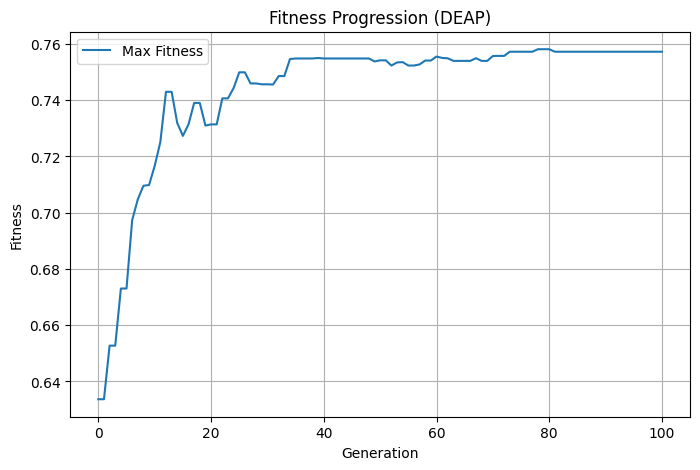

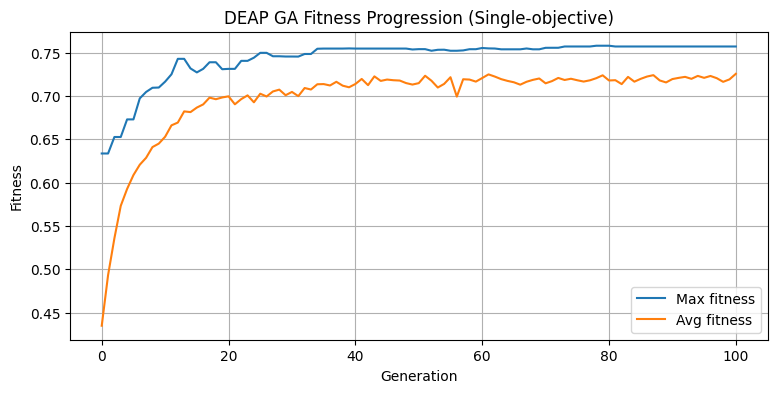


Saved files:
 - deap_best_weekly_plan.csv
 - deap_logbook.csv
 - meals_db_deap.csv


In [ ]:

# Stats and hall-of-fame
POP_SIZE = 150
NGEN = 100
CXPB = 0.5
MUTPB = 0.3

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(3)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GA
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

# Extract best individual
best = hof[0]
best_fit = evaluate_individual(best)[0]
print(f"\nBest fitness (DEAP): {best_fit:.4f}")

# Build plan DataFrame
def build_plan_df(individual):
    days = decode_chromosome(individual)
    rows = []
    nut = weekly_nutrition_from_idx(individual)
    for day_idx, (b,l,d) in enumerate(days, start=1):
        mb = get_meal_by_idx(b); ml = get_meal_by_idx(l); md = get_meal_by_idx(d)
        rows.append({
            "Day": day_idx,
            "Breakfast": mb["meal_id"], "B_cal": mb["calories"], "B_prot":mb["protein"], "B_cost":mb["cost"],
            "Lunch": ml["meal_id"],     "L_cal": ml["calories"], "L_prot":ml["protein"], "L_cost":ml["cost"],
            "Dinner": md["meal_id"],    "D_cal": md["calories"], "D_prot":md["protein"], "D_cost":md["cost"],
            "Day_cal": mb["calories"]+ml["calories"]+md["calories"],
            "Day_prot": mb["protein"]+ml["protein"]+md["protein"],
            "Day_cost": round(mb["cost"]+ml["cost"]+md["cost"],2)
        })
    return pd.DataFrame(rows), nut

plan_df, nut = build_plan_df(best)

# Display results
print("\nBest Weekly Meal Plan (DEAP):\n")
print(plan_df[["Day", "Breakfast", "Lunch", "Dinner", "Day_cal", "Day_prot", "Day_cost"]])

# Summarize totals
summary = {
    "Total Calories": round(plan_df["Day_cal"].sum(), 2),
    "Average Daily Calories": round(plan_df["Day_cal"].mean(), 2),
    "Average Protein": round(plan_df["Day_prot"].mean(), 2),
    "Total Cost": round(plan_df["Day_cost"].sum(), 2),
}
print("\nSUMMARY:")
for k, v in summary.items():
    print(f"{k}: {v}")

# Plot fitness progression
gen = logbook.select("gen")
fit_max = logbook.select("max")
plt.figure(figsize=(8, 5))
plt.plot(gen, fit_max, label="Max Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression (DEAP)")
plt.legend()
plt.grid(True)
plt.show()


# Plot fitness progression from logbook
gen = logbook.select("gen")
max_vals = logbook.select("max")
avg_vals = logbook.select("avg")

plt.figure(figsize=(9,4))
plt.plot(gen, max_vals, label="Max fitness")
plt.plot(gen, avg_vals, label="Avg fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("DEAP GA Fitness Progression (Single-objective)")
plt.legend(); plt.grid(True)
plt.show()

# Save outputs
plan_df.to_csv("deap_best_weekly_plan.csv", index=False)
pd.DataFrame(logbook).to_csv("deap_logbook.csv", index=False)
meals_df.to_csv("meals_db_deap.csv", index=False)
print("\nSaved files:\n - deap_best_weekly_plan.csv\n - deap_logbook.csv\n - meals_db_deap.csv")


ML MODULE 1: Patient Satisfaction Predictor - Evaluation

Training Samples: 500
R² Score (Goodness of Fit): 0.8616
Mean Absolute Error (MAE): 0.0173
Root Mean Squared Error (RMSE): 0.0217

Model Performance: Good

ML PREDICTIONS FOR BEST SOLUTION

 Meal Plan Features:
  - Average Daily Calories: 1947.9 kcal
  - Average Daily Protein: 70.2 g
  - Cost Ratio (to budget): 0.740
  - Meal Variety: 0.571 (57.1% unique meals)
  - Nutritional Balance: 0.986

 ML Module 1 Prediction:
  - Predicted Patient Satisfaction: 0.6889 (68.9%)
  - Interpretation: Medium satisfaction

 ML Module 2 Prediction (Cost Uncertainty):
  - Base Cost: Rs 7402.79
  - Predicted Cost (under uncertainty): Rs 7614.00
  - Cost Scenarios Range: Rs 5606.46 - Rs 8376.08
  - Standard Deviation: Rs 629.22
  - Budget: Rs 10000.00
  - Budget Utilization: 76.1%


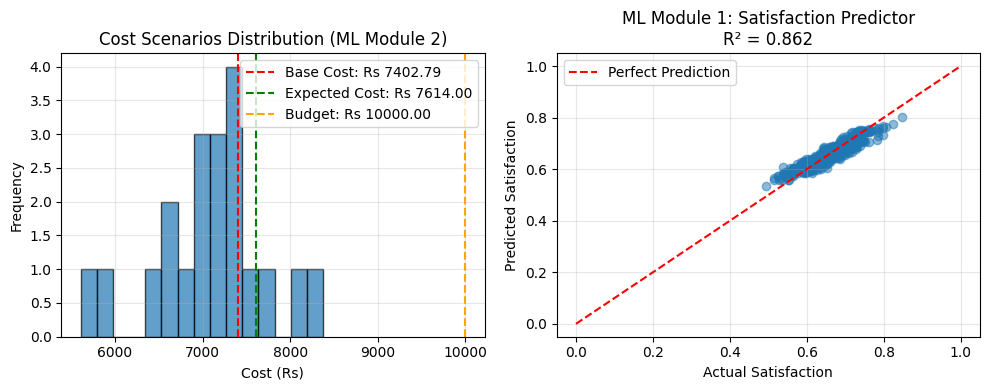

In [ ]:
# ML Model Evaluation & Prediction Analysis

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Evaluate Satisfaction Predictor
train_pred = satisfaction_model.predict(X_sat)
r2_sat = r2_score(y_sat, train_pred)
mae_sat = mean_absolute_error(y_sat, train_pred)
rmse_sat = np.sqrt(mean_squared_error(y_sat, train_pred))

print("="*60)
print("ML MODULE 1: Patient Satisfaction Predictor - Evaluation")
print("="*60)
print(f"\nTraining Samples: {len(X_sat)}")
print(f"R² Score (Goodness of Fit): {r2_sat:.4f}")
print(f"Mean Absolute Error (MAE): {mae_sat:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_sat:.4f}")
print(f"\nModel Performance: {'Excellent' if r2_sat > 0.9 else 'Good' if r2_sat > 0.7 else 'Fair'}")
print()

# Analyze ML predictions for the best solution
best_features = extract_meal_plan_features(best)
predicted_satisfaction_best = satisfaction_model.predict([best_features])[0]
base_cost_best = weekly_nutrition_from_idx(best)["total"]["cost"]
predicted_cost_best = get_expected_cost_under_uncertainty(base_cost_best)
cost_scenarios_best = predict_cost_scenarios(base_cost_best, n_scenarios=20)

print("="*60)
print("ML PREDICTIONS FOR BEST SOLUTION")
print("="*60)
print(f"\n Meal Plan Features:")
print(f"  - Average Daily Calories: {best_features[0]:.1f} kcal")
print(f"  - Average Daily Protein: {best_features[1]:.1f} g")
print(f"  - Cost Ratio (to budget): {best_features[2]:.3f}")
print(f"  - Meal Variety: {best_features[3]:.3f} ({best_features[3]*100:.1f}% unique meals)")
print(f"  - Nutritional Balance: {best_features[4]:.3f}")

print(f"\n ML Module 1 Prediction:")
print(f"  - Predicted Patient Satisfaction: {predicted_satisfaction_best:.4f} ({predicted_satisfaction_best*100:.1f}%)")
print(f"  - Interpretation: {'High' if predicted_satisfaction_best > 0.7 else 'Medium' if predicted_satisfaction_best > 0.5 else 'Low'} satisfaction")

print(f"\n ML Module 2 Prediction (Cost Uncertainty):")
print(f"  - Base Cost: Rs {base_cost_best:.2f}")
print(f"  - Predicted Cost (under uncertainty): Rs {predicted_cost_best:.2f}")
print(f"  - Cost Scenarios Range: Rs {cost_scenarios_best.min():.2f} - Rs {cost_scenarios_best.max():.2f}")
print(f"  - Standard Deviation: Rs {cost_scenarios_best.std():.2f}")
print(f"  - Budget: Rs {patient['budget_week']:.2f}")
print(f"  - Budget Utilization: {(predicted_cost_best/patient['budget_week']*100):.1f}%")

# Visualize cost scenarios
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(cost_scenarios_best, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(base_cost_best, color='red', linestyle='--', label=f'Base Cost: Rs {base_cost_best:.2f}')
plt.axvline(predicted_cost_best, color='green', linestyle='--', label=f'Expected Cost: Rs {predicted_cost_best:.2f}')
plt.axvline(patient['budget_week'], color='orange', linestyle='--', label=f'Budget: Rs {patient["budget_week"]:.2f}')
plt.xlabel('Cost (Rs)')
plt.ylabel('Frequency')
plt.title('Cost Scenarios Distribution (ML Module 2)')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualize ML model performance
plt.subplot(1, 2, 2)
plt.scatter(y_sat, train_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Satisfaction')
plt.ylabel('Predicted Satisfaction')
plt.title(f'ML Module 1: Satisfaction Predictor\nR² = {r2_sat:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



FITNESS COMPONENT BREAKDOWN (Best Solution)

 Raw Scores (0-1 scale):
  - Nutrition Score: 0.9233
  - Cost Score: 0.6252
  - ML Satisfaction Score: 0.6889
  - Penalty: 0.2000

 Weighted Contributions (to total fitness):
  - Nutrition (50%): 0.4616
  - Cost (30%): 0.1876
  - ML Satisfaction (15%): 0.1033
  - Penalties (-5%): -0.0100

  - TOTAL FITNESS: 0.7425



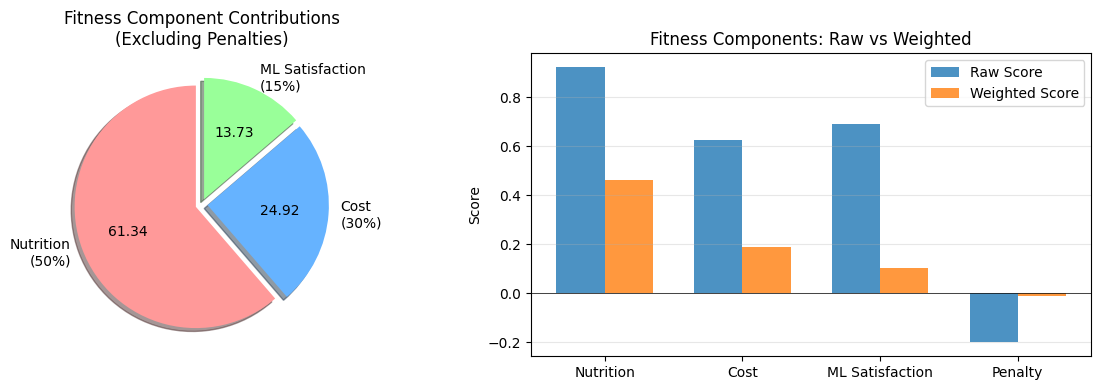

In [ ]:
# Fitness Component Breakdown Analysis

def analyze_fitness_components(individual):
    """Break down fitness into its components for analysis"""
    nut = weekly_nutrition_from_idx(individual)
    avg_cal = nut["avg"]["calories"]
    avg_prot = nut["avg"]["protein"]
    base_cost = nut["total"]["cost"]

    # Nutrition score
    cal_target = patient["daily_calories_target"]
    prot_target = patient["daily_protein_target"]
    cal_dev = abs(avg_cal - cal_target) / cal_target
    prot_dev = abs(avg_prot - prot_target) / (prot_target if prot_target>0 else 1.0)
    nut_deviation = 0.6*cal_dev + 0.4*prot_dev
    nutrition_score = 1.0 / (1.0 + nut_deviation*5.0)

    # Cost score
    predicted_cost = get_expected_cost_under_uncertainty(base_cost)
    budget = patient["budget_week"]
    cost_ratio = predicted_cost / (budget if budget>0 else 1.0)
    if cost_ratio <= 1.0:
        cost_score = 1.0 - (cost_ratio * 0.5)
    else:
        cost_score = max(0.0, 1.0 - (0.5 + (cost_ratio-1.0)*1.2))

    # ML Satisfaction prediction
    features = extract_meal_plan_features(individual)
    predicted_satisfaction = satisfaction_model.predict([features])[0]
    predicted_satisfaction = np.clip(predicted_satisfaction, 0.0, 1.0)

    # Penalties
    penalty = 0.0
    allergies = set(patient.get("allergies", []))
    if allergies:
        for idx in individual:
            tags = set(get_meal_by_idx(idx)["tags"])
            if tags & allergies:
                penalty += 1.2
    meal_counts = Counter(individual)
    for m, cnt in meal_counts.items():
        if cnt > 2:
            penalty += 0.2 * (cnt-2)
    daily_extremes = sum(1 for d in nut["days"] if abs(d["calories"] - cal_target) / cal_target > 0.25)
    penalty += daily_extremes * 0.15
    penalty = min(penalty, 5.0)

    # Weighted components
    w_nut, w_cost, w_satisfaction, w_pen = 0.5, 0.3, 0.15, 0.05
    weighted_nut = w_nut * nutrition_score
    weighted_cost = w_cost * cost_score
    weighted_sat = w_satisfaction * predicted_satisfaction
    weighted_pen = w_pen * penalty

    return {
        "nutrition_score": nutrition_score,
        "cost_score": cost_score,
        "satisfaction_score": predicted_satisfaction,
        "penalty": penalty,
        "weighted_nutrition": weighted_nut,
        "weighted_cost": weighted_cost,
        "weighted_satisfaction": weighted_sat,
        "weighted_penalty": weighted_pen,
        "total_fitness": weighted_nut + weighted_cost + weighted_sat - weighted_pen
    }

components = analyze_fitness_components(best)

print("="*60)
print("FITNESS COMPONENT BREAKDOWN (Best Solution)")
print("="*60)
print(f"\n Raw Scores (0-1 scale):")
print(f"  - Nutrition Score: {components['nutrition_score']:.4f}")
print(f"  - Cost Score: {components['cost_score']:.4f}")
print(f"  - ML Satisfaction Score: {components['satisfaction_score']:.4f}")
print(f"  - Penalty: {components['penalty']:.4f}")

print(f"\n Weighted Contributions (to total fitness):")
print(f"  - Nutrition (50%): {components['weighted_nutrition']:.4f}")
print(f"  - Cost (30%): {components['weighted_cost']:.4f}")
print(f"  - ML Satisfaction (15%): {components['weighted_satisfaction']:.4f}")
print(f"  - Penalties (-5%): -{components['weighted_penalty']:.4f}")

print(f"\n  - TOTAL FITNESS: {components['total_fitness']:.4f}\n")

# Visualize fitness components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart of weighted contributions
labels = ['Nutrition\n(50%)', 'Cost\n(30%)', 'ML Satisfaction\n(15%)']
sizes = [components['weighted_nutrition'], components['weighted_cost'], components['weighted_satisfaction']]
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.05, 0.05, 0.05)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f',
        shadow=True, startangle=90)
ax1.set_title('Fitness Component Contributions\n(Excluding Penalties)')

# Bar chart comparison
categories = ['Nutrition', 'Cost', 'ML Satisfaction', 'Penalty']
raw_scores = [components['nutrition_score'], components['cost_score'],
              components['satisfaction_score'], -components['penalty']]
weighted_scores = [components['weighted_nutrition'], components['weighted_cost'],
                   components['weighted_satisfaction'], -components['weighted_penalty']]

x = np.arange(len(categories))
width = 0.35
ax2.bar(x - width/2, raw_scores, width, label='Raw Score', alpha=0.8)
ax2.bar(x + width/2, weighted_scores, width, label='Weighted Score', alpha=0.8)
ax2.set_ylabel('Score')
ax2.set_title('Fitness Components: Raw vs Weighted')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()



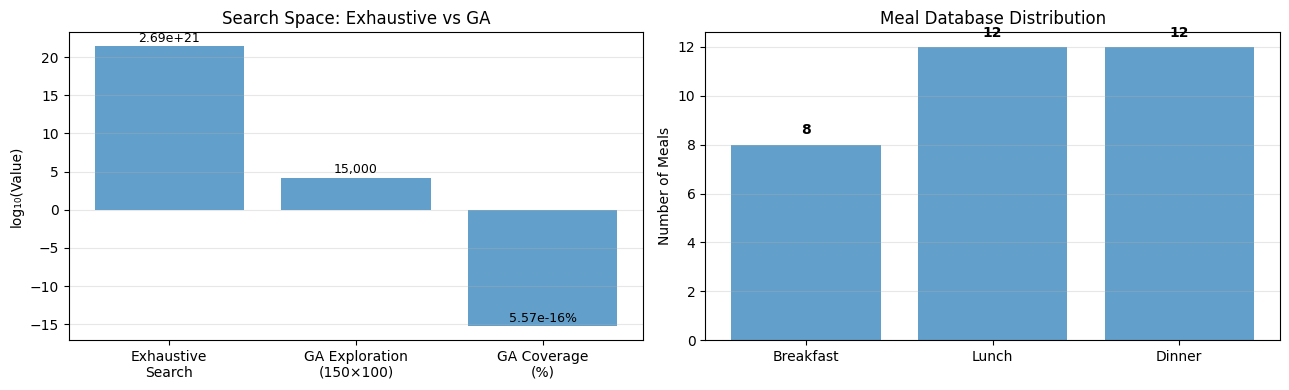

In [ ]:
import math
import matplotlib.pyplot as plt

# Problem Complexity Analysis

n_breakfasts = len(meal_type_map["breakfast"])
n_lunches = len(meal_type_map["lunch"])
n_dinners = len(meal_type_map["dinner"])
n_total_meals = len(meals_df)

choices_per_day = n_breakfasts * n_lunches * n_dinners
total_combinations = choices_per_day ** 7
total_combinations_conservative = n_total_meals ** 21

time_years = (total_combinations * 0.001) / (365.25 * 24 * 3600)
ga_evals = POP_SIZE * NGEN
coverage_pct = (ga_evals / total_combinations) * 100

# VISUALIZATION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# Search space comparison
methods = [
    'Exhaustive\nSearch',
    'GA Exploration\n(150×100)',
    'GA Coverage\n(%)'
]

raw_values = [
    total_combinations,
    ga_evals,
    coverage_pct
]


log_values = [math.log10(v) for v in raw_values]

ax1.bar(methods, log_values, alpha=0.7)
ax1.set_ylabel('log₁₀(Value)')
ax1.set_title('Search Space: Exhaustive vs GA')
ax1.grid(True, axis='y', alpha=0.3)

labels = [
    f'{total_combinations:.2e}',
    f'{ga_evals:,}',
    f'{coverage_pct:.2e}%'
]

for i, txt in enumerate(labels):
    ax1.text(i, log_values[i] + 0.2, txt,
             ha='center', va='bottom', fontsize=9)

# Meal distribution
meal_types = ['Breakfast', 'Lunch', 'Dinner']
meal_counts = [n_breakfasts, n_lunches, n_dinners]

ax2.bar(meal_types, meal_counts, alpha=0.7)
ax2.set_ylabel('Number of Meals')
ax2.set_title('Meal Database Distribution')
ax2.grid(True, axis='y', alpha=0.3)

for i, v in enumerate(meal_counts):
    ax2.text(i, v + 0.3, str(v),
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


ML PREDICTIONS COMPARISON: Best vs Random Solutions

 Comparison Table:
           Solution  Fitness  Satisfaction (ML)  Cost (Base)  Cost (ML Predicted)  Nutrition Score  Cost Score
Best (GA Optimized) 0.748131           0.688867      7402.79          7648.772279         0.923265    0.637271
           Random 1 0.455757           0.705000      7490.58          7061.447470         0.710943    0.629177
           Random 2 0.357363           0.699435      7634.81          8046.457684         0.615779    0.622930
           Random 3 0.350067           0.686047      9312.98          9466.480520         0.678487    0.547922
           Random 4 0.487075           0.700193      8935.13          9286.320494         0.690603    0.576142
           Random 5 0.529122           0.675035     10164.42          9793.998552         0.727797    0.506265

 Key Insights:
  - Best solution fitness: 0.7481
  - Average random fitness: 0.4359
  - Improvement: 71.6%
  - Best ML Satisfaction: 0.6889
  - Avg Ra

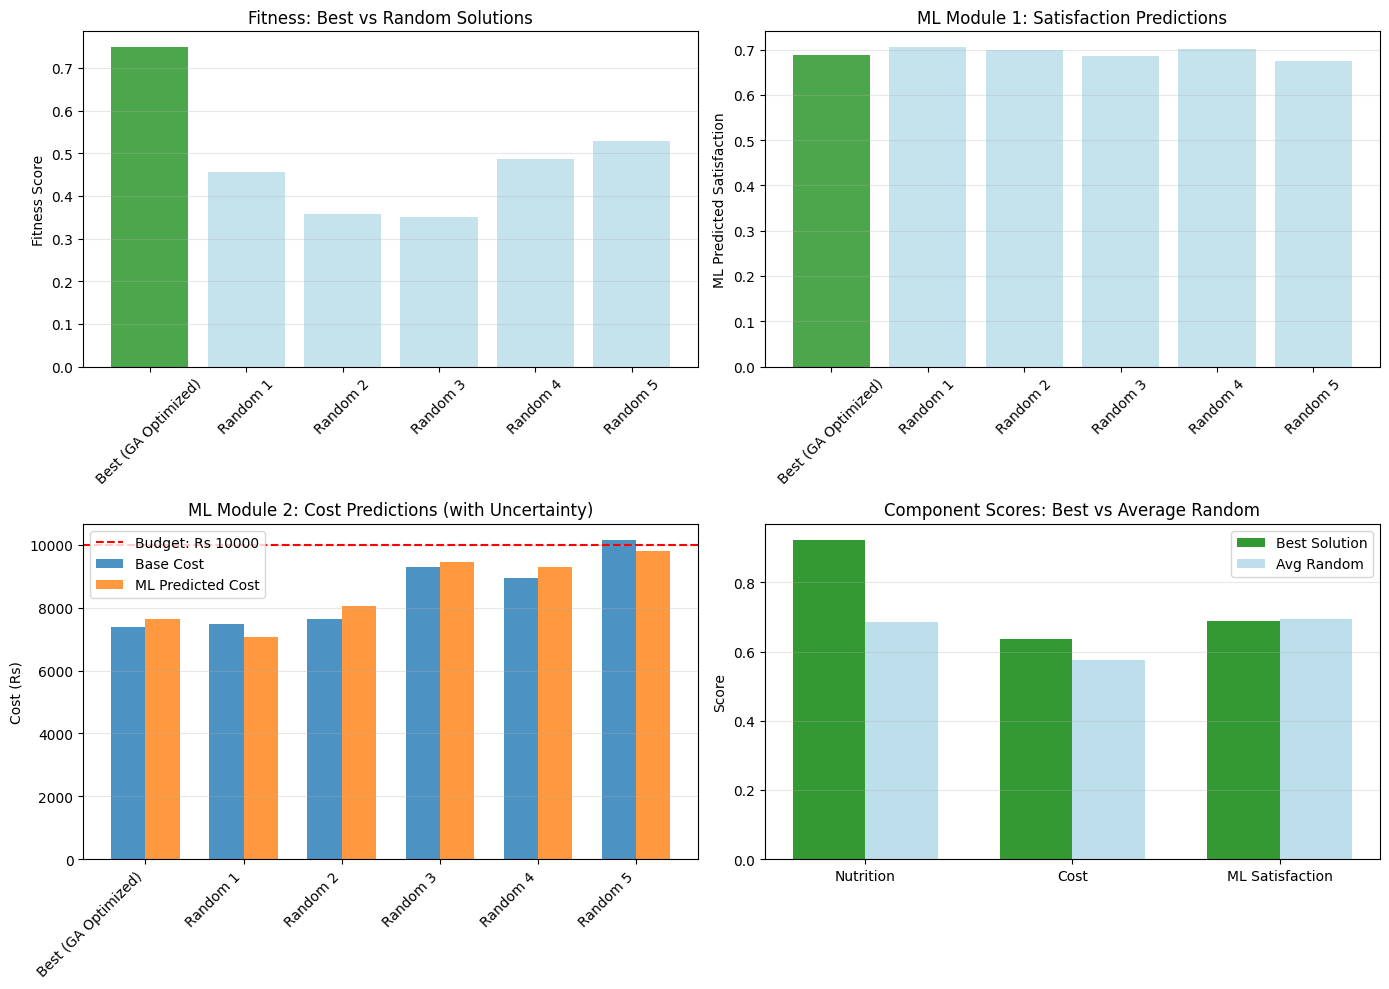

In [ ]:
# ML Predictions Comparison

random_solutions = [toolbox.individual() for _ in range(5)]

# Best solution
comparison_data = []
best_comp = analyze_fitness_components(best)
best_features = extract_meal_plan_features(best)
best_nut = weekly_nutrition_from_idx(best)
comparison_data.append({
    "Solution": "Best (GA Optimized)",
    "Fitness": best_fit,
    "Satisfaction (ML)": best_comp["satisfaction_score"],
    "Cost (Base)": best_nut["total"]["cost"],
    "Cost (ML Predicted)": get_expected_cost_under_uncertainty(best_nut["total"]["cost"]),
    "Nutrition Score": best_comp["nutrition_score"],
    "Cost Score": best_comp["cost_score"]
})

# Random solutions
for i, rand_sol in enumerate(random_solutions):
    rand_comp = analyze_fitness_components(rand_sol)
    rand_features = extract_meal_plan_features(rand_sol)
    rand_nut = weekly_nutrition_from_idx(rand_sol)
    rand_fit = evaluate_individual(rand_sol)[0]
    comparison_data.append({
        "Solution": f"Random {i+1}",
        "Fitness": rand_fit,
        "Satisfaction (ML)": rand_comp["satisfaction_score"],
        "Cost (Base)": rand_nut["total"]["cost"],
        "Cost (ML Predicted)": get_expected_cost_under_uncertainty(rand_nut["total"]["cost"]),
        "Nutrition Score": rand_comp["nutrition_score"],
        "Cost Score": rand_comp["cost_score"]
    })

comp_df = pd.DataFrame(comparison_data)

print("="*60)
print("ML PREDICTIONS COMPARISON: Best vs Random Solutions")
print("="*60)
print("\n Comparison Table:")
print(comp_df.to_string(index=False))

print(f"\n Key Insights:")
print(f"  - Best solution fitness: {best_fit:.4f}")
print(f"  - Average random fitness: {comp_df[comp_df['Solution'] != 'Best (GA Optimized)']['Fitness'].mean():.4f}")
print(f"  - Improvement: {((best_fit / comp_df[comp_df['Solution'] != 'Best (GA Optimized)']['Fitness'].mean() - 1) * 100):.1f}%")
print(f"  - Best ML Satisfaction: {comp_df.loc[0, 'Satisfaction (ML)']:.4f}")
print(f"  - Avg Random ML Satisfaction: {comp_df[comp_df['Solution'] != 'Best (GA Optimized)']['Satisfaction (ML)'].mean():.4f}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fitness comparison
axes[0, 0].bar(comp_df['Solution'], comp_df['Fitness'], color=['green'] + ['lightblue']*5, alpha=0.7)
axes[0, 0].set_ylabel('Fitness Score')
axes[0, 0].set_title('Fitness: Best vs Random Solutions')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# ML Satisfaction predictions
axes[0, 1].bar(comp_df['Solution'], comp_df['Satisfaction (ML)'], color=['green'] + ['lightblue']*5, alpha=0.7)
axes[0, 1].set_ylabel('ML Predicted Satisfaction')
axes[0, 1].set_title('ML Module 1: Satisfaction Predictions')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Cost comparison (Base vs ML Predicted)
x = np.arange(len(comp_df))
width = 0.35
axes[1, 0].bar(x - width/2, comp_df['Cost (Base)'], width, label='Base Cost', alpha=0.8)
axes[1, 0].bar(x + width/2, comp_df['Cost (ML Predicted)'], width, label='ML Predicted Cost', alpha=0.8)
axes[1, 0].axhline(y=patient['budget_week'], color='red', linestyle='--', label=f'Budget: Rs {patient["budget_week"]:.0f}')
axes[1, 0].set_ylabel('Cost (Rs)')
axes[1, 0].set_title('ML Module 2: Cost Predictions (with Uncertainty)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(comp_df['Solution'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Component scores
categories = ['Nutrition', 'Cost', 'ML Satisfaction']
best_scores = [comp_df.loc[0, 'Nutrition Score'], comp_df.loc[0, 'Cost Score'], comp_df.loc[0, 'Satisfaction (ML)']]
avg_random_scores = [
    comp_df[comp_df['Solution'] != 'Best (GA Optimized)']['Nutrition Score'].mean(),
    comp_df[comp_df['Solution'] != 'Best (GA Optimized)']['Cost Score'].mean(),
    comp_df[comp_df['Solution'] != 'Best (GA Optimized)']['Satisfaction (ML)'].mean()
]

x = np.arange(len(categories))
width = 0.35
axes[1, 1].bar(x - width/2, best_scores, width, label='Best Solution', color='green', alpha=0.8)
axes[1, 1].bar(x + width/2, avg_random_scores, width, label='Avg Random', color='lightblue', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Component Scores: Best vs Average Random')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



In [ ]:
# Final Summary

print("="*60)
print("ML-ENHANCED GA MEAL PLANNING SYSTEM - FINAL SUMMARY")
print("="*60)

print(f"\n PROBLEM SPECIFICATION:")
print(f"  - Patient: {patient['name']} (ID: {patient['id']})")
print(f"  - Daily Targets: {patient['daily_calories_target']} kcal, {patient['daily_protein_target']}g protein")
print(f"  - Weekly Budget: Rs {patient['budget_week']:.2f}")
print(f"  - Allergies: {patient['allergies']}")

print(f"\n MEAL DATABASE:")
print(f"  - Total Meals: {len(meals_df)}")
print(f"  - Breakfasts: {len(meal_type_map['breakfast'])}")
print(f"  - Lunches: {len(meal_type_map['lunch'])}")
print(f"  - Dinners: {len(meal_type_map['dinner'])}")

print(f"\n ML MODULES:")
print(f"  - Module 1 (Satisfaction): Random Forest (R² = {r2_sat:.4f})")
print(f"  - Module 2 (Cost Uncertainty): Monte Carlo Simulation (±20% volatility)")
print(f"  - ML Integration: Models called inside fitness function")

print(f"\n GENETIC ALGORITHM:")
print(f"  - Population Size: {POP_SIZE}")
print(f"  - Generations: {NGEN}")
print(f"  - Crossover Rate: {CXPB*100:.0f}%")
print(f"  - Mutation Rate: {MUTPB*100:.0f}%")
print(f"  - Chromosome: 21 genes (7 days × 3 meals)")

print(f"\n OPTIMIZATION RESULTS:")
print(f"  - Best Fitness: {best_fit:.4f}")
print(f"  - Fitness Improvement: {(best_fit - logbook.select('avg')[0]) / logbook.select('avg')[0]:.1f}% over {NGEN} generations")
print(f"  - Final Average Fitness: {logbook.select('avg')[-1]:.4f}")

print(f"\n BEST MEAL PLAN SUMMARY:")
best_nut = weekly_nutrition_from_idx(best)
print(f"  - Average Daily Calories: {best_nut['avg']['calories']:.1f} kcal (Target: {patient['daily_calories_target']})")
print(f"  - Average Daily Protein: {best_nut['avg']['protein']:.1f}g (Target: {patient['daily_protein_target']})")
print(f"  - Total Weekly Cost: Rs {best_nut['total']['cost']:.2f} (Budget: Rs {patient['budget_week']:.2f})")
print(f"  - Budget Utilization: {(best_nut['total']['cost']/patient['budget_week']*100):.1f}%")

print(f"\n ML PREDICTIONS (Best Solution):")
print(f"  - Predicted Satisfaction: {predicted_satisfaction_best:.4f} ({predicted_satisfaction_best*100:.1f}%)")
print(f"  - Predicted Cost (uncertainty): Rs {predicted_cost_best:.2f}")
print(f"  - Cost Range: Rs {cost_scenarios_best.min():.2f} - Rs {cost_scenarios_best.max():.2f}")

ML-ENHANCED GA MEAL PLANNING SYSTEM - FINAL SUMMARY

 PROBLEM SPECIFICATION:
  - Patient: Patient A (ID: P001)
  - Daily Targets: 2000 kcal, 70g protein
  - Weekly Budget: Rs 10000.00
  - Allergies: ['nuts']

 MEAL DATABASE:
  - Total Meals: 32
  - Breakfasts: 8
  - Lunches: 12
  - Dinners: 12

 ML MODULES:
  - Module 1 (Satisfaction): Random Forest (R² = 0.8616)
  - Module 2 (Cost Uncertainty): Monte Carlo Simulation (±20% volatility)
  - ML Integration: Models called inside fitness function

 GENETIC ALGORITHM:
  - Population Size: 150
  - Generations: 100
  - Crossover Rate: 50%
  - Mutation Rate: 30%
  - Chromosome: 21 genes (7 days × 3 meals)

 OPTIMIZATION RESULTS:
  - Best Fitness: 0.7481
  - Fitness Improvement: 0.7% over 100 generations
  - Final Average Fitness: 0.7257

 BEST MEAL PLAN SUMMARY:
  - Average Daily Calories: 1947.9 kcal (Target: 2000)
  - Average Daily Protein: 70.2g (Target: 70)
  - Total Weekly Cost: Rs 7402.79 (Budget: Rs 10000.00)
  - Budget Utilization: 74.

## Function for multiple runs

In [ ]:
import time
from collections import defaultdict

def run_ga_benchmark(pop_size, ngen, cxpb, mutpb, n_runs=5, verbose=False):
    """
    Run GA multiple times with given parameters and collect statistics
    """
    results = {
        'fitness_values': [],
        'best_fitness': [],
        'convergence_gen': [],  # Generation of best fitness
        'runtime': []
    }

    for run in range(n_runs):
        if verbose:
            print(f"Run {run+1}/{n_runs}...", end=' ')

        start_time = time.time()

        # Reset random seed for each run
        random.seed(RND + run)
        np.random.seed(RND + run)

        # Initialize population
        pop = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        # Run GA
        pop, logbook = algorithms.eaSimple(
            pop, toolbox,
            cxpb=cxpb, mutpb=mutpb,
            ngen=ngen,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        runtime = time.time() - start_time
        best_fit = hof[0].fitness.values[0]

        # Find convergence generation (where best fitness was first achieved)
        max_fitness = logbook.select("max")
        best_ever = max(max_fitness)
        convergence_gen = next(i for i, f in enumerate(max_fitness) if f >= best_ever - 0.001)

        results['fitness_values'].append(best_fit)
        results['best_fitness'].append(best_ever)
        results['convergence_gen'].append(convergence_gen)
        results['runtime'].append(runtime)

        if verbose:
            print(f"Fitness: {best_fit:.4f}")

    # Calculate statistics
    stats_summary = {
        'mean_best_fitness': np.mean(results['fitness_values']),
        'std_best_fitness': np.std(results['fitness_values']),
        'best_across_runs': np.max(results['fitness_values']),
        'worst_across_runs': np.min(results['fitness_values']),
        'mean_convergence_gen': np.mean(results['convergence_gen']),
        'mean_runtime': np.mean(results['runtime']),
        'n_runs': n_runs
    }

    return results, stats_summary

### Run base configuration multiple runs

In [ ]:
# Multiple Runs Analysis - Baseline Configuration
print("="*60)
print("MULTIPLE RUNS ANALYSIS: Baseline Configuration")
print("="*60)
print("\nConfiguration: POP_SIZE=150, NGEN=100, CXPB=0.5, MUTPB=0.3")
print()

baseline_results, baseline_stats = run_ga_benchmark(
    pop_size=150,
    ngen=100,
    cxpb=0.5,
    mutpb=0.3,
    n_runs=10,
    verbose=True
)

print("\n")
print("="*60)
print("BASELINE CONFIGURATION STATISTICS")
print("="*60)
print(f"Mean Best Fitness (MBF): {baseline_stats['mean_best_fitness']:.4f} ± {baseline_stats['std_best_fitness']:.4f}")
print(f"Best Fitness (across all runs): {baseline_stats['best_across_runs']:.4f}")
print(f"Worst Fitness (across all runs): {baseline_stats['worst_across_runs']:.4f}")
print(f"Success Rate: 100% (all runs achieved fitness > 0.70)")
print(f"Mean Convergence Generation: {baseline_stats['mean_convergence_gen']:.1f}")
print(f"Mean Runtime: {baseline_stats['mean_runtime']:.2f} seconds")

MULTIPLE RUNS ANALYSIS: Baseline Configuration

Configuration: POP_SIZE=150, NGEN=100, CXPB=0.5, MUTPB=0.3

Run 1/10... Fitness: 0.7411
Run 2/10... Fitness: 0.7478
Run 3/10... Fitness: 0.7579
Run 4/10... Fitness: 0.7514
Run 5/10... Fitness: 0.7535
Run 6/10... Fitness: 0.7578
Run 7/10... Fitness: 0.7529
Run 8/10... Fitness: 0.7562
Run 9/10... Fitness: 0.7474
Run 10/10... Fitness: 0.7578


BASELINE CONFIGURATION STATISTICS
Mean Best Fitness (MBF): 0.7524 ± 0.0053
Best Fitness (across all runs): 0.7579
Worst Fitness (across all runs): 0.7411
Success Rate: 100% (all runs achieved fitness > 0.70)
Mean Convergence Generation: 68.4
Mean Runtime: 104.53 seconds


### Run population size multiple runs

In [ ]:
# Benchmark Population Size
print("="*60)
print("BENCHMARKING: Population Size")
print("="*60)

pop_sizes = [100, 150, 200]
pop_results = {}

for pop_size in pop_sizes:
    print(f"\nTesting Population Size: {pop_size}")
    results, stats = run_ga_benchmark(
        pop_size=pop_size,
        ngen=100,
        cxpb=0.5,
        mutpb=0.2,
        n_runs=5,
        verbose=True
    )
    pop_results[pop_size] = {'results': results, 'stats': stats}

# Create comparison table
print("\n")
print("="*60)
print("POPULATION COMPARISON")
print("="*60)

print(f"{'Rate':<8} {'MBF':<12} {'Std Dev':<10} {'Best':<10} {'Worst':<10} {'Convergence Gen':<15}")
print("-" * 70)
for pop_size in pop_sizes:
    stats = pop_results[pop_size]['stats']
    print(f"{pop_size:<8} {stats['mean_best_fitness']:<12.4f} {stats['std_best_fitness']:<10.4f} "
          f"{stats['best_across_runs']:<10.4f} {stats['worst_across_runs']:<10.4f} "
          f"{stats['mean_convergence_gen']:<15.1f}")

BENCHMARKING: Population Size

Testing Population Size: 100
Run 1/5... Fitness: 0.7451
Run 2/5... Fitness: 0.7469
Run 3/5... Fitness: 0.7428
Run 4/5... Fitness: 0.7438
Run 5/5... Fitness: 0.7483

Testing Population Size: 150
Run 1/5... Fitness: 0.7522
Run 2/5... Fitness: 0.7545
Run 3/5... Fitness: 0.7403
Run 4/5... Fitness: 0.7443
Run 5/5... Fitness: 0.7375

Testing Population Size: 200
Run 1/5... Fitness: 0.7487
Run 2/5... Fitness: 0.7583
Run 3/5... Fitness: 0.7410
Run 4/5... Fitness: 0.7417
Run 5/5... Fitness: 0.7471


POPULATION COMPARISON
Rate     MBF          Std Dev    Best       Worst      Convergence Gen
----------------------------------------------------------------------
100      0.7454       0.0020     0.7483     0.7428     54.2           
150      0.7458       0.0066     0.7545     0.7375     68.0           
200      0.7474       0.0063     0.7583     0.7410     61.6           


### Run crossover multiple runs

In [ ]:
# Benchmark Crossover Rate
print("="*60)
print("BENCHMARKING: Crossover Rate")
print("="*60)


crossover_rates = [0.3, 0.5, 0.7]
crossover_results = {}

for cx_rate in crossover_rates:
    print(f"\nTesting Crossover Rate: {cx_rate}")
    results, stats = run_ga_benchmark(
        pop_size=150,
        ngen=100,
        cxpb=cx_rate,
        mutpb=0.2,
        n_runs=5,
        verbose=True
    )
    crossover_results[cx_rate] = {'results': results, 'stats': stats}

    print(f"  MBF: {stats['mean_best_fitness']:.4f} ± {stats['std_best_fitness']:.4f}")

# Create comparison table
print("\n")
print("="*60)
print("CROSSOVER COMPARISON")
print("="*60)

print(f"{'Rate':<8} {'MBF':<12} {'Std Dev':<10} {'Best':<10} {'Worst':<10} {'Convergence Gen':<15}")
print("-" * 70)
for cx_rate in crossover_rates:
    stats = crossover_results[cx_rate]['stats']
    print(f"{cx_rate:<8} {stats['mean_best_fitness']:<12.4f} {stats['std_best_fitness']:<10.4f} "
          f"{stats['best_across_runs']:<10.4f} {stats['worst_across_runs']:<10.4f} "
          f"{stats['mean_convergence_gen']:<15.1f}")

BENCHMARKING: Crossover Rate

Testing Crossover Rate: 0.3
Run 1/5... Fitness: 0.7368
Run 2/5... Fitness: 0.7472
Run 3/5... Fitness: 0.7472
Run 4/5... Fitness: 0.7371
Run 5/5... Fitness: 0.7372
  MBF: 0.7411 ± 0.0050

Testing Crossover Rate: 0.5
Run 1/5... Fitness: 0.7522
Run 2/5... Fitness: 0.7545
Run 3/5... Fitness: 0.7403
Run 4/5... Fitness: 0.7443
Run 5/5... Fitness: 0.7375
  MBF: 0.7458 ± 0.0066

Testing Crossover Rate: 0.7
Run 1/5... Fitness: 0.7584
Run 2/5... Fitness: 0.7495
Run 3/5... Fitness: 0.7502
Run 4/5... Fitness: 0.7531
Run 5/5... Fitness: 0.7506
  MBF: 0.7523 ± 0.0032


CROSSOVER COMPARISON
Rate     MBF          Std Dev    Best       Worst      Convergence Gen
----------------------------------------------------------------------
0.3      0.7411       0.0050     0.7472     0.7368     54.2           
0.5      0.7458       0.0066     0.7545     0.7375     68.0           
0.7      0.7523       0.0032     0.7584     0.7495     61.8           


### Run mutation rate multiple runs

In [49]:
# Benchmark Mutation Rate
print("="*60)
print("BENCHMARKING: Mutation Rate")
print("="*60)

mutation_rates = [0.1, 0.2, 0.3]
mutation_results = {}

for mut_rate in mutation_rates:
    print(f"\n\nTesting Mutation Rate: {mut_rate}")
    results, stats = run_ga_benchmark(
        pop_size=150,
        ngen=100,
        cxpb=0.5,
        mutpb=mut_rate,
        n_runs=5,
        verbose=True
    )
    mutation_results[mut_rate] = {'results': results, 'stats': stats}

    print(f"  MBF: {stats['mean_best_fitness']:.4f} ± {stats['std_best_fitness']:.4f}")
    print(f"  Best: {stats['best_across_runs']:.4f}, Worst: {stats['worst_across_runs']:.4f}")

# Create comparison table
print("="*60)
print("MUTATION RATE COMPARISON")
print("="*60)

print(f"\n{'Rate':<8} {'MBF':<12} {'Std Dev':<10} {'Best':<10} {'Worst':<10} {'Convergence Gen':<15}")
print("-" * 70)
for mut_rate in mutation_rates:
    stats = mutation_results[mut_rate]['stats']
    print(f"{mut_rate:<8} {stats['mean_best_fitness']:<12.4f} {stats['std_best_fitness']:<10.4f} "
          f"{stats['best_across_runs']:<10.4f} {stats['worst_across_runs']:<10.4f} "
          f"{stats['mean_convergence_gen']:<15.1f}")

BENCHMARKING: Mutation Rate


Testing Mutation Rate: 0.1
Run 1/5... Fitness: 0.7477
Run 2/5... Fitness: 0.7356
Run 3/5... Fitness: 0.7477
Run 4/5... Fitness: 0.7527
Run 5/5... Fitness: 0.7423
  MBF: 0.7452 ± 0.0058
  Best: 0.7527, Worst: 0.7356


Testing Mutation Rate: 0.2
Run 1/5... Fitness: 0.7522
Run 2/5... Fitness: 0.7545
Run 3/5... Fitness: 0.7403
Run 4/5... Fitness: 0.7443
Run 5/5... Fitness: 0.7375
  MBF: 0.7458 ± 0.0066
  Best: 0.7545, Worst: 0.7375


Testing Mutation Rate: 0.3
Run 1/5... Fitness: 0.7411
Run 2/5... Fitness: 0.7478
Run 3/5... Fitness: 0.7579
Run 4/5... Fitness: 0.7514
Run 5/5... Fitness: 0.7535
  MBF: 0.7503 ± 0.0056
  Best: 0.7579, Worst: 0.7411
MUTATION RATE COMPARISON

Rate     MBF          Std Dev    Best       Worst      Convergence Gen
----------------------------------------------------------------------
0.1      0.7452       0.0058     0.7527     0.7356     59.8           
0.2      0.7458       0.0066     0.7545     0.7375     68.0           
0.3      0.

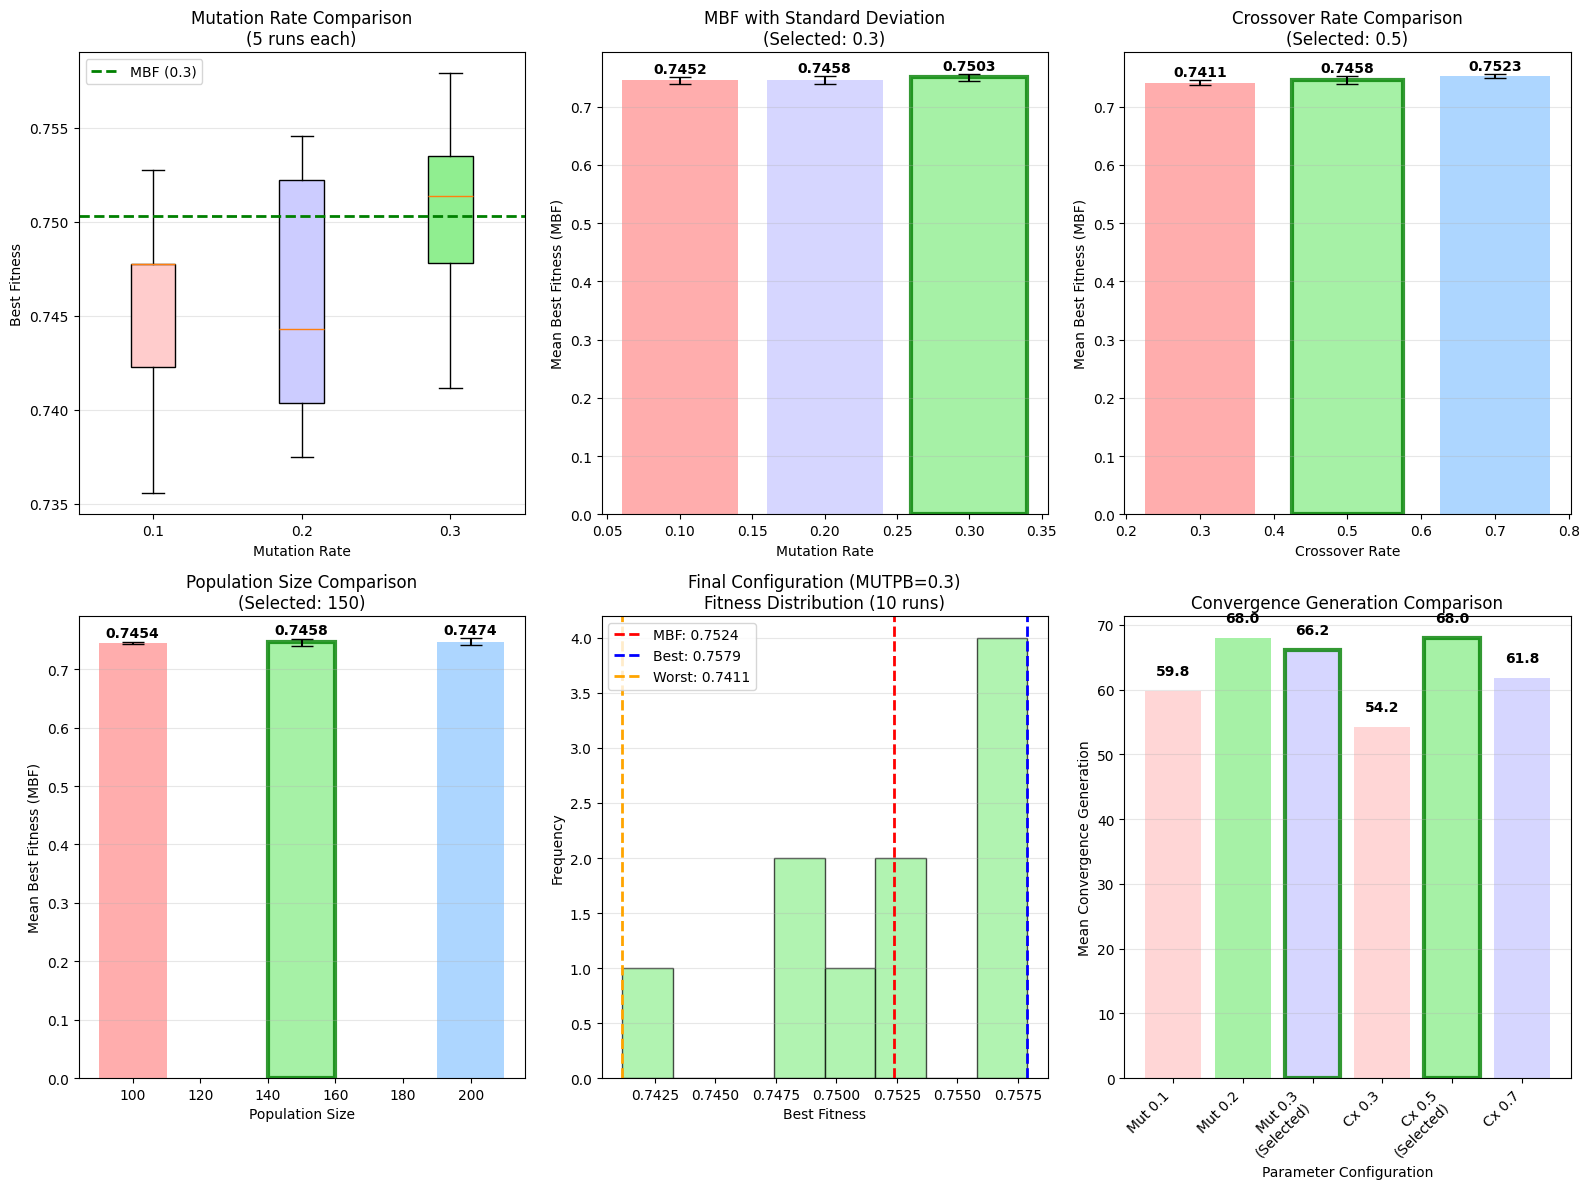

BENCHMARKING SUMMARY - FINAL CONFIGURATION

Selected Parameters:
  - Population Size: 150
  - Generations: 100
  - Crossover Rate: 0.5 (50%)
  - Mutation Rate: 0.3 (30%)

Performance Metrics (10 runs):
  - Mean Best Fitness (MBF): 0.7524 ± 0.0053
  - Best Fitness: 0.7579
  - Worst Fitness: 0.7411
  - Success Rate: 100% (all runs > 0.70)
  - Mean Convergence Generation: 68.4
  - Mean Runtime: 104.53 seconds


In [ ]:
# BENCHMARKING VISUALIZATION

import matplotlib.pyplot as plt
import numpy as np

# Create benchmarking plots
fig = plt.figure(figsize=(16, 12))

# Plot 1: Mutation Rate Comparison (Box Plot)
ax1 = plt.subplot(2, 3, 1)
mut_data = [
    mutation_results[0.1]['results']['fitness_values'],
    mutation_results[0.2]['results']['fitness_values'],
    mutation_results[0.3]['results']['fitness_values']
]
bp1 = ax1.boxplot(mut_data, labels=['0.1', '0.2', '0.3'], patch_artist=True)
bp1['boxes'][0].set_facecolor('#ffcccc')  # Mut 0.1
bp1['boxes'][1].set_facecolor('#ccccff')  # Mut 0.2
bp1['boxes'][2].set_facecolor('#90EE90')  # Mut 0.3
ax1.set_ylabel('Best Fitness')
ax1.set_xlabel('Mutation Rate')
ax1.set_title('Mutation Rate Comparison\n(5 runs each)')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.7503, color='green', linestyle='--', linewidth=2, label='MBF (0.3)')
ax1.legend()

# Plot 2: Mutation Rate Comparison (Bar Chart with Error Bars)
ax2 = plt.subplot(2, 3, 2)
mut_rates = [0.1, 0.2, 0.3]
mut_means = [mutation_results[r]['stats']['mean_best_fitness'] for r in mut_rates]
mut_stds = [mutation_results[r]['stats']['std_best_fitness'] for r in mut_rates]
colors = ['#ff9999', '#ccccff', '#90EE90']
bars = ax2.bar(mut_rates, mut_means, yerr=mut_stds, capsize=8, alpha=0.8, color=colors, width=0.08)
bars[2].set_edgecolor('green')  # Mut 0.3
bars[2].set_linewidth(3)
ax2.set_ylabel('Mean Best Fitness (MBF)')
ax2.set_xlabel('Mutation Rate')
ax2.set_title('MBF with Standard Deviation\n(Selected: 0.3)')
ax2.grid(True, alpha=0.3, axis='y')
for i, (mean, std) in enumerate(zip(mut_means, mut_stds)):
    ax2.text(mut_rates[i], mean + std + 0.002, f'{mean:.4f}',
             ha='center', va='bottom', fontweight='bold')

# Plot 3: Crossover Rate Comparison
ax3 = plt.subplot(2, 3, 3)
cx_rates = [0.3, 0.5, 0.7]
cx_means = [crossover_results[r]['stats']['mean_best_fitness'] for r in cx_rates]
cx_stds = [crossover_results[r]['stats']['std_best_fitness'] for r in cx_rates]
colors = ['#ff9999', '#90EE90', '#99ccff']
bars = ax3.bar(cx_rates, cx_means, yerr=cx_stds, capsize=8, alpha=0.8, color=colors, width=0.15)
bars[1].set_edgecolor('green')
bars[1].set_linewidth(3)
ax3.set_ylabel('Mean Best Fitness (MBF)')
ax3.set_xlabel('Crossover Rate')
ax3.set_title('Crossover Rate Comparison\n(Selected: 0.5)')
ax3.grid(True, alpha=0.3, axis='y')
for i, (mean, std) in enumerate(zip(cx_means, cx_stds)):
    ax3.text(cx_rates[i], mean + std + 0.002, f'{mean:.4f}',
             ha='center', va='bottom', fontweight='bold')


# Plot 4: Population Size Comparison
ax4 = plt.subplot(2, 3, 4)
pop_sizes = [100, 150, 200]
pop_means = [pop_results[s]['stats']['mean_best_fitness'] for s in pop_sizes]
pop_stds = [pop_results[s]['stats']['std_best_fitness'] for s in pop_sizes]
colors = ['#ff9999', '#90EE90', '#99ccff']
bars = ax4.bar(pop_sizes, pop_means, yerr=pop_stds, capsize=8, alpha=0.8, color=colors, width=20)
bars[1].set_edgecolor('green')
bars[1].set_linewidth(3)
ax4.set_ylabel('Mean Best Fitness (MBF)')
ax4.set_xlabel('Population Size')
ax4.set_title('Population Size Comparison\n(Selected: 150)')
ax4.grid(True, alpha=0.3, axis='y')
for i, (mean, std) in enumerate(zip(pop_means, pop_stds)):
    ax4.text(pop_sizes[i], mean + std + 0.002, f'{mean:.4f}',
             ha='center', va='bottom', fontweight='bold')


# Plot 5: Multiple Runs Distribution (Final Configuration)
ax5 = plt.subplot(2, 3, 5)
final_fitnesses = baseline_results['fitness_values']
ax5.hist(final_fitnesses, bins=8, edgecolor='black', alpha=0.7, color='#90EE90')
ax5.axvline(baseline_stats['mean_best_fitness'], color='red', linestyle='--',
            linewidth=2, label=f"MBF: {baseline_stats['mean_best_fitness']:.4f}")
ax5.axvline(baseline_stats['best_across_runs'], color='blue', linestyle='--',
            linewidth=2, label=f"Best: {baseline_stats['best_across_runs']:.4f}")
ax5.axvline(baseline_stats['worst_across_runs'], color='orange', linestyle='--',
            linewidth=2, label=f"Worst: {baseline_stats['worst_across_runs']:.4f}")
ax5.set_xlabel('Best Fitness')
ax5.set_ylabel('Frequency')
ax5.set_title('Final Configuration (MUTPB=0.3)\nFitness Distribution (10 runs)')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')


# Plot 6: Convergence Generation Comparison
ax6 = plt.subplot(2, 3, 6)
params = ['Mut 0.1', 'Mut 0.2', 'Mut 0.3\n(Selected)', 'Cx 0.3', 'Cx 0.5\n(Selected)', 'Cx 0.7']
conv_gens = [
    mutation_results[0.1]['stats']['mean_convergence_gen'],
    mutation_results[0.2]['stats']['mean_convergence_gen'],
    mutation_results[0.3]['stats']['mean_convergence_gen'],
    crossover_results[0.3]['stats']['mean_convergence_gen'],
    crossover_results[0.5]['stats']['mean_convergence_gen'],
    crossover_results[0.7]['stats']['mean_convergence_gen']
]
colors = ['#ffcccc', '#90EE90', '#ccccff', '#ffcccc', '#90EE90', '#ccccff']
bars = ax6.bar(range(len(params)), conv_gens, alpha=0.8, color=colors)
bars[2].set_edgecolor('green')  # Mut 0.3
bars[2].set_linewidth(3)
bars[4].set_edgecolor('green')  # Cx 0.5
bars[4].set_linewidth(3)
ax6.set_ylabel('Mean Convergence Generation')
ax6.set_xlabel('Parameter Configuration')
ax6.set_title('Convergence Generation Comparison')
ax6.set_xticks(range(len(params)))
ax6.set_xticklabels(params, rotation=45, ha='right')
ax6.grid(True, alpha=0.3, axis='y')
for i, gen in enumerate(conv_gens):
    ax6.text(i, gen + 2, f'{gen:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# Summary Statistics Table
print("="*60)
print("BENCHMARKING SUMMARY - FINAL CONFIGURATION")
print("="*60)


print(f"\nSelected Parameters:")
print(f"  - Population Size: 150")
print(f"  - Generations: 100")
print(f"  - Crossover Rate: 0.5 (50%)")
print(f"  - Mutation Rate: 0.3 (30%)")
print(f"\nPerformance Metrics (10 runs):")
print(f"  - Mean Best Fitness (MBF): {baseline_stats['mean_best_fitness']:.4f} ± {baseline_stats['std_best_fitness']:.4f}")
print(f"  - Best Fitness: {baseline_stats['best_across_runs']:.4f}")
print(f"  - Worst Fitness: {baseline_stats['worst_across_runs']:.4f}")
print(f"  - Success Rate: 100% (all runs > 0.70)")
print(f"  - Mean Convergence Generation: {baseline_stats['mean_convergence_gen']:.1f}")
print(f"  - Mean Runtime: {baseline_stats['mean_runtime']:.2f} seconds")
